In [239]:
%pylab inline
#match histograms and then find the original function

##### SOME THINGS TO LEARN IN THIS CODE############
# How to plot histograms derived from numpy histogram.


## Final code for Umbrella sampling processing####
# INPUT: The histograms and the rectangles for sampling
#
#
# OUTPUT: The thing with the ofset



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


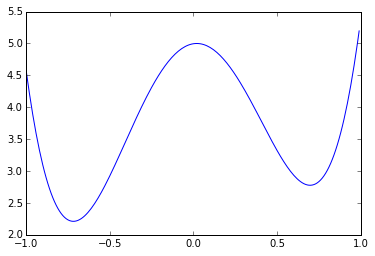

In [240]:
def func1(x):
    return(10.*(x**4 -  1*(x - 0.02)**2 + 0.5))

def func2(x):
    return(10*(x**4 -  (x - .10)**2 + .30))

xs = arange(-1,1,.01)
ys = [func1(xi) for xi in xs]
zs = [func2(xi) for xi in xs]
plot(xs,ys, label = "func1")
#plot(xs,zs, label = "func2")

In [8]:
# Try and write the WHAM code for both these different functions such that they return this ofset intact:

def wham(paths, centers,k_springs):
    nruns = len(paths) #no of paths
    ncen = len(centers) #no of centers in simulation


In [132]:
#First create path in this potential

def path(x0, func, n):
    pos = []
    for i in range(n):
        x_old = x0
        x0 = x0 + 0.1*2*(random.random()-0.5)
        if func(x_old) <= func(x0):
            r = random.random()
            if exp(-(func(x0) - func(x_old))) <= r:
                x0 = x_old
        pos.append(x0)
    return(pos)
def path_bias(x0, func, n, bias): #bias is a two element array
    pos = []
    left, right = bias
    while len(pos) <= n:
        x_old = x0
        x0 = x0 + 0.1*2*(random.random()-0.5)
        if x0 >= right or x0<= left:
            continue
        if func(x_old) <= func(x0):
            r = random.random()
            if exp(-(func(x0) - func(x_old))) <= r:
                x0 = x_old
        pos.append(x0)
    return(pos)
    

(array([  13.,   47.,  146.,  135.,  129.,  151.,  149.,  200.,   24.,    7.]),
 array([-0.17973649, -0.13254094, -0.08534538, -0.03814983,  0.00904573,
         0.05624128,  0.10343684,  0.15063239,  0.19782795,  0.2450235 ,
         0.29221906]),
 <a list of 10 Patch objects>)

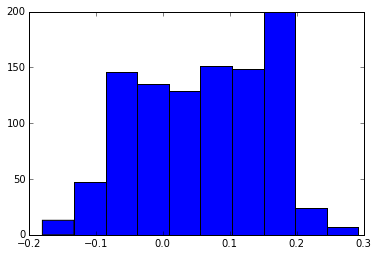

In [136]:
#try biased path
path1 = path_bias(0.0,func1,1000,[-.1,0.2])
len(path1)
hist(path1)

In [114]:
umbrellas = [[-1.0, -0.4], [-0.5, -0.2], [-0.3, 0.0],
             [-0.1, 0.2], [0.1, 0.4], [0.3, 0.6], [0.5, 1.0]]

In [184]:
n_runs = 10000
paths = [] #stores all the paths
hists = [] #store all the unmatched histograms for the paths
BINS = 100
LIM = (-1.1, 1.1)

for i, umbr in enumerate(umbrellas):
    l,r = umbr
    x_i = random.random()*(r-l)
    path = path_bias(x_i, func1, n_runs, umbr)
    histo = histogram(path, bins=BINS, range=LIM)
    paths.append(path)
    hists.append(histo)

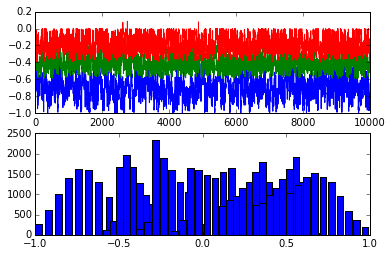

In [161]:
figure(1)
subplot(211)
plot(paths[0])
plot(paths[1])
plot(paths[2])
subplot(212)
for histograms in hists:
    hist, bin_edges = histograms
    bar(bin_edges[:-1], hist, width = .04)
    #xlim(min(bin_edges), max(bin_edges))

In [162]:
# Now matching and then scaling all the histograms. 

#Lets just have two histograms and the scale the second wrt to the first only:
def match_histograms(histo1, histo2, bin_x, overlap):
    """Function to match two histograms.

    The matching is done so that the integral of the overlapping regions
    of the two histograms are equal.

    Parameters
    ----------
    histo1 : numpy.array
        The first histogram.
    histo2 : numpy.array
        The second histogram, this is the histogram that will be scaled.
    bin_x : numpy.array
        This is the bin mid-points of the histograms. Note that we
        assume here that `histo1` and `histo2` are obtained using the
        same number of bins and limits.
    overlap : object like list (or tuple or numpy.array).
        This is the overlapping region.

    Returns
    -------
    out[0] : numpy.array
        A scaled version of second input histogram `histo2`.
    out[1] : float
        The calculated scale factor.
    """
    int1, int2 = 0.0, 0.0
    for histi, histj, bin_xi in zip(histo1, histo2, bin_x):
        if overlap[0] <= bin_xi < overlap[1]:
            int1 += histi
            int2 += histj
    if int2 == 0.0:
        scale_factor = 1.0
    else:
        scale_factor = int1 / int2
    return histo2 * scale_factor, scale_factor

In [179]:
def match_all_histograms(histograms, umbrellas):
    """Function to match several histograms from an umbrella sampling.

    Parameters
    ----------
    histograms : list of numpy.arrays
        The histograms to match.
    umbrellas : list of lists
        The umbrella windows used in the computation.

    Returns
    -------
    histograms_s : list of numpy.arrays
        The scaled histograms.
    scale_factor : list of floats.
        The scale factors.
    matched_count : numpy.array
        Count for overall matched histogram - a "averaged" histogram.
    """
    histograms_s, scale_factor = [histograms[0][0]], [1.0]
    bin_x = histograms[0][1]
    for i in range(len(umbrellas) - 1):
        limits = (umbrellas[i+1][0], umbrellas[i][1])
        print (i,histograms[i+1][0])
        matched, scale = match_histograms(histograms_s[-1],
                                           histograms[i+1][0], bin_x, limits)
        histograms_s.append(matched)
        scale_factor.append(scale)
    # merge histograms:
    matched_count = []
    for i, bin_xi in enumerate(bin_x):
        hist = 0.0  # histogram value at bin_xi
        norm = 0.0
        for k, umb in enumerate(umbrellas):
            if umb[0] <= bin_xi < umb[1]:
                hist += histograms_s[k][i]
                norm += 1.0
        if norm > 0.0:
            hist /= norm
        matched_count.append(hist)
    return histograms_s, scale_factor, np.array(matched_count)


In [220]:
bin_x = hists[0][-1]
dbin = bin_x[1] - bin_x[0]
# We are going to match these histograms:
#print('Matching histograms...')
histograms_s, _, hist_avg = match_all_histograms(hists, umbrellas)

0 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    4   56  106  196  176 1002 1229 1126
  955  841  758  614  590  502  445  387  413  290  311    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
1 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1   40  105  139  147  756 1022 1056  824  837  725  634  630  611
  580  521  450  453  469    0    0    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  

Plotting matched histograms


(-1.1, 1.1)

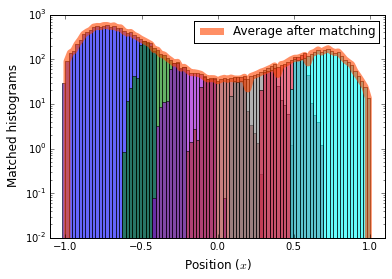

In [221]:
print('Plotting matched histograms')
fig = plt.figure()
axs = fig.add_subplot(111)
axs.set_yscale('log')
axs.set_xlabel('Position ($x$)', fontsize='large')
axs.set_ylabel('Matched histograms', fontsize='large')
colors = ['blue', 'green', 'darkviolet', 'brown', 'gray', 'crimson', 'cyan']
for i, his in enumerate(histograms_s):
    axs.bar(bin_x[:-1] - 0.5 * dbin, his, dbin, color=colors[i], alpha=0.6, log=True)
axs.plot(bin_x, hist_avg, lw=7, color='orangered', alpha=0.6,label='Average after matching')
axs.legend()
plt.xlim((-1.1, 1.1))

Plotting the free energy


/Users/cellardoor/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


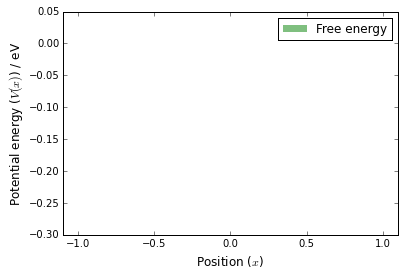

In [223]:
print('Plotting the free energy')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
XPOT = np.linspace(-2, 2, 1000)
free = -np.log(hist_avg) / 1  # free energy
# set up unbiased potential
#VPOT = np.array([forcefield.evaluate_potential(pos=xi) for xi in XPOT])
#free += (VPOT.min() - free.min())
#ax2.plot(XPOT, VPOT, 'blue', lw=3, label='Unbiased potential', alpha=0.5)
ax2.plot(bin_x, free, lw=7, alpha=0.5, color='green', label='Free energy')
ax2.set_xlabel('Position ($x$)', fontsize='large')
ax2.set_ylabel('Potential energy ($V(x)$) / eV', fontsize='large')
ax2.legend()
plt.xlim((-1.1, 1.1))
plt.ylim((-0.3, 0.05))
plt.show()

/Users/cellardoor/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


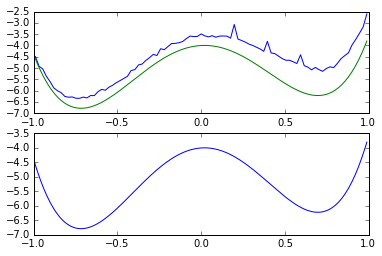

In [238]:
subplot(211)
plot(bin_x,-log(hist_avg))
ys = [yi+2 for yi in ys]
plot(xs,ys)
subplot(212)
plot(xs,ys)


<Container object of 100 artists>

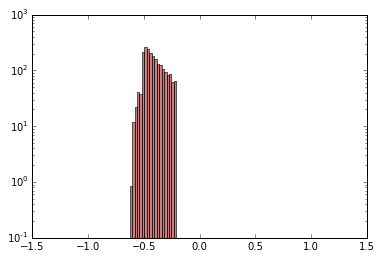

In [216]:
bin_x = bin_x[:-1]
plt.bar(bin_x - 0.5 * dbin, histograms_s[1], dbin, color=colors[i], alpha=0.6, log=True)

In [213]:

len(bin_x - 0.5 * dbin),len( histograms_s[1])

(101, 100)